# CME241 (Winter 2021) -- Assignment 10

In [1]:
import abc
from dataclasses import dataclass, asdict
from typing import Iterator, Tuple

import numpy as np
import pandas as pd

## Question 2

In [2]:
@dataclass
class Simulator(abc.ABC):
    
    S_0: float = 100
    T: float = 1.0
    dt: float = 0.005
    sigma:float = 2.0
    k: float = 1.5
    c: float = 140.0
        
    def was_hit(self, mid: float, bid: float) -> bool:
        """Determine if we bought by probability."""
        delta = mid - bid
        prob = self.c * np.exp(-1.0 * self.k * delta) * self.dt
        return np.random.rand() < prob
        
    def was_lifted(self, mid: float, ask: float) -> bool:
        """Determine if we sold by probability."""
        delta = ask - mid
        prob = self.c * np.exp(-1.0 * self.k * delta) * self.dt
        return np.random.rand() < prob
        
    @dataclass
    class State:
        """Capture all relevant state material."""
        
        time: float
        inventory: int
        midpoint: float
        bid: float
        ask: float
        pnl: float
        
    def simulate(self) -> Iterator[State]:
        """Generate a single simulation sequence."""
        time = inventory = pnl = 0
        midpoint = self.S_0
        bid, ask = self.price(midpoint, inventory, time)
        while time < self.T:
            yield Simulator.State(
                time=time, 
                midpoint=midpoint, 
                inventory=inventory, 
                bid=bid, 
                ask=ask, 
                pnl=pnl
            )
            if self.was_hit(midpoint, bid):
                inventory += 1
                pnl -= bid
            if self.was_lifted(midpoint, ask):
                inventory -= 1
                pnl += ask
            mvmt = np.random.choice([-1, 1])
            midpoint += mvmt * self.sigma * np.sqrt(self.dt)
            bid, ask = self.price(midpoint, inventory, time)
            time += self.dt
        # and now we have to liquidate our remaining inventory
        pnl += inventory * midpoint
        yield Simulator.State(
            time=self.T, 
            midpoint=midpoint, 
            inventory=0, 
            bid=bid, 
            ask=ask, 
            pnl=pnl
        )
            
    @abc.abstractmethod
    def price(self, mdpt: float, inventory: int) -> Tuple[float, float]:
        """Compute the market making prices."""
        pass

In [3]:
@dataclass
class OptimalMarketMaker(Simulator):
    
    gamma: float = 0.1
    
    def price(self, mid: float, inventory: int, t: float) -> Tuple[float, float]:
        """Compute the Avallaneda-Stoikov optimal MM prices."""
        db = self.db(inventory, t)
        da = self.da(inventory, t)
        return mid - db, mid + da
    
    def db(self, I: int, t: float) -> float:
        """Compute MM bid spread."""
        const = (2 * I + 1) * self.gamma * np.square(self.sigma) * (self.T - t) / 2
        return const + np.log(1 + self.gamma / self.k) / self.gamma
    
    def da(self, I: int, t: float) -> float:
        """Compute MM ask spread."""
        const = (1 - 2 * I) * self.gamma * np.square(self.sigma) * (self.T - t) / 2
        return const + np.log(1 + self.gamma / self.k) / self.gamma

In [4]:
opt_mm = OptimalMarketMaker()

In [5]:
n = 1000

max_inventory = []
ending_pnl = []
avg_spread = []

for i in range(n):
    trace = list(opt_mm.simulate())
    ending_pnl.append(trace[-1].pnl)
    inventory = 0
    spread_sum = 0
    for step in trace:
        inventory = max(abs(step.inventory), inventory)
        spread_sum += step.ask - step.bid
    
    max_inventory.append(inventory)
    avg_spread.append(spread_sum / len(trace))
    
df = pd.DataFrame({
    "max_abs_inventory": max_inventory,
    "ending_pnl": ending_pnl,
    "avg_spread": avg_spread
})

In [6]:
df

,max_abs_inventory,ending_pnl,avg_spread
0,6,57.877184,1.49276
1,3,56.855029,1.49276
2,3,58.313586,1.49276
3,6,66.036601,1.49276
4,5,60.437369,1.49276
...,...,...,...
995,5,65.259329,1.49276
996,3,72.537625,1.49276
997,3,62.408960,1.49276
998,3,65.611751,1.49276


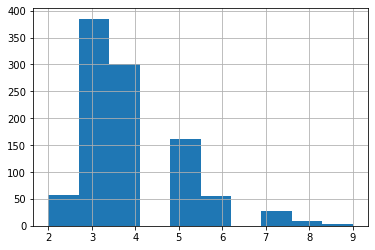

In [7]:
df["max_abs_inventory"].hist()

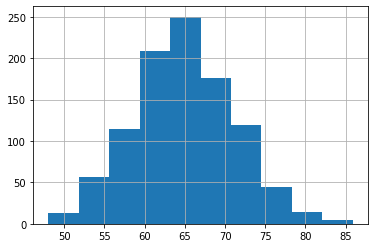

In [8]:
df["ending_pnl"].hist()

In [9]:
@dataclass
class NaiveMarketMaker(Simulator):
    
    avg_spread: float = 1.49276
    
    def price(self, mid: float, inventory: int, t: float) -> Tuple[float, float]:
        """Compute the Avallaneda-Stoikov optimal MM prices."""
        half = self.avg_spread / 2
        return mid - half, mid + half

In [10]:
naive_mm = NaiveMarketMaker()

In [11]:
n = 1000

max_inventory = []
ending_pnl = []
avg_spread = []

for i in range(n):
    trace = list(naive_mm.simulate())
    ending_pnl.append(trace[-1].pnl)
    inventory = 0
    spread_sum = 0
    for step in trace:
        inventory = max(abs(step.inventory), inventory)
        spread_sum += step.ask - step.bid
    
    max_inventory.append(inventory)
    avg_spread.append(spread_sum / len(trace))
    
df = pd.DataFrame({
    "max_abs_inventory": max_inventory,
    "ending_pnl": ending_pnl,
    "avg_spread": avg_spread
})

In [12]:
df

,max_abs_inventory,ending_pnl,avg_spread
0,18,90.194349,1.49276
1,18,81.386952,1.49276
2,11,70.136118,1.49276
3,6,65.508676,1.49276
4,5,68.156219,1.49276
...,...,...,...
995,13,69.146169,1.49276
996,8,63.513105,1.49276
997,10,84.686846,1.49276
998,13,74.693134,1.49276


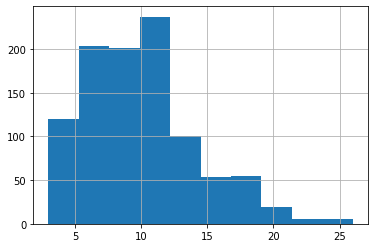

In [13]:
df["max_abs_inventory"].hist()

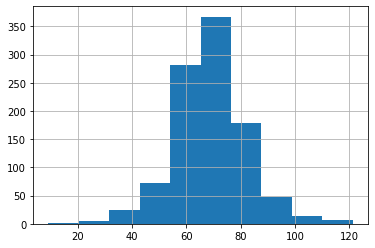

In [14]:
df["ending_pnl"].hist()

In [15]:
# 